# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

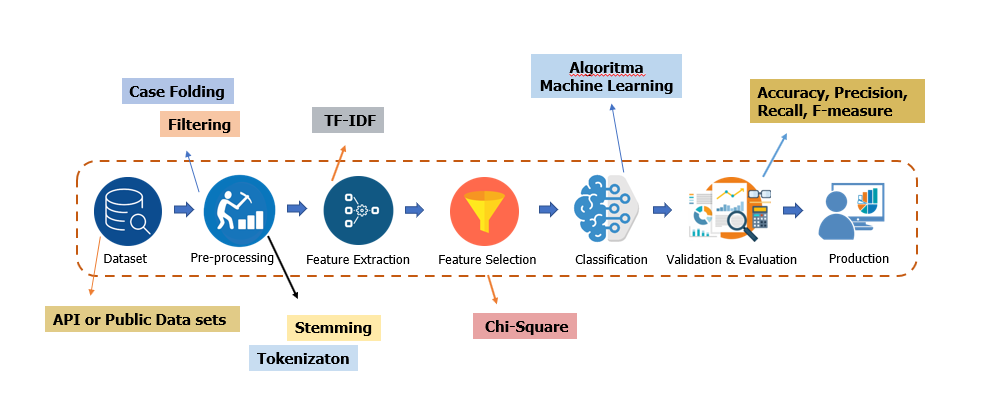

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
# Install library Sastrawi
!pip -q install sastrawi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.7 MB/s eta 0:00:00


In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# 01 Data Acquisition

Penjelasan Label 
* 0: Kalimat normal 
* 1: Kalimat Cyberbullying

In [4]:
# Download dataset
!wget https://raw.githubusercontent.com/RomySyaputra/cyberbullying/main/DatasetCyberbullying.csv

--2023-05-23 13:01:19--  https://raw.githubusercontent.com/RomySyaputra/cyberbullying/main/DatasetCyberbullying.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203245 (198K) [text/plain]
Saving to: ‘DatasetCyberbullying.csv’

DatasetCyberbullyin 100%[===================>] 198.48K  --.-KB/s    in 0.02s   

2023-05-23 13:01:19 (12.3 MB/s) - ‘DatasetCyberbullying.csv’ saved [203245/203245]



In [5]:
data = pd.read_csv('DatasetCyberbullying.csv',encoding='utf-8')
data.head()

,teks,label
0,"Kaka tidur yaa, udah pagi, gaboleh capek2",no
1,makan nasi padang aja begini badannya,no
2,Hai kak Isyana aku ngefans banget sama kak Isy...,no
3,Manusia apa bidadari sih herann deh cantik ter...,no
4,"Gemesnya isyan kayak tango, berlapis lapis ciaaaa",no


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1850 entries, 0 to 1849
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   teks    1850 non-null   object
 1   label   1850 non-null   object
dtypes: object(2)
memory usage: 29.0+ KB


In [7]:
print('Total Jumlah Teks:', data.shape[0], 'data\n')
print('terdiri dari (label):')
print('-- [0] Teks Normal\t:', data[data.label == "no"].shape[0], 'data')
print('-- [1] Teks Cyberbullying\t:', data[data.label == "yes"].shape[0], 'data')

Total Jumlah Teks: 1850 data

terdiri dari (label):
-- [0] Teks Normal	: 925 data
-- [1] Teks Cyberbullying	: 925 data


In [8]:
height = data['label'].value_counts()
print(height)

no     925
yes    925
Name: label, dtype: int64


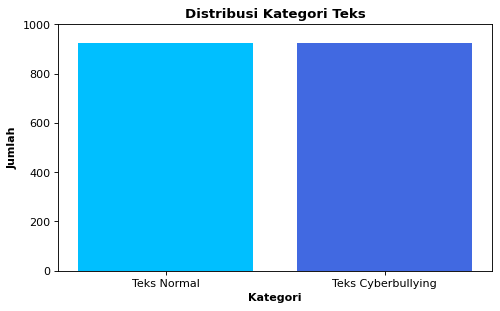

In [9]:
height = data['label'].value_counts()
labels = ('Teks Normal', 'Teks Cyberbullying')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,1000)
plt.title('Distribusi Kategori Teks', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [10]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [11]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya. Sesimple itu
Case folding	:  anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya sesimple itu


## Word Normalization

In [12]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/RomySyaputra/cyberbullying/main/key_norm.csv

--2023-05-23 13:01:20--  https://raw.githubusercontent.com/RomySyaputra/cyberbullying/main/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136884 (134K) [text/plain]
Saving to: ‘key_norm.csv’

key_norm.csv        100%[===================>] 133.68K  --.-KB/s    in 0.01s   

2023-05-23 13:01:20 (9.64 MB/s) - ‘key_norm.csv’ saved [136884/136884]



In [13]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(5224, 3)

In [14]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [15]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [16]:
len(stopwords_ind)

758

In [17]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [18]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['bro', 'mas', 'utk', 'yg', 'zzzzz']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [19]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya. Sesimple itu
Case folding		:  anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya sesimple itu
Stopword removal	:  anak cerdas terbentuk dr pola asuh pola didik ortu cerdas sih saranya sesimple


## Stemming

In [20]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [21]:
raw_sample = data['teks'].iloc[5]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya. Sesimple itu
Case folding		:  anak yg cerdas terbentuk dr pola asuh sekaligus pola didik ortu yg cerdas pula sih pada saranya sesimple itu
Stopword removal	:  anak cerdas terbentuk dr pola asuh pola didik ortu cerdas sih saranya sesimple
Stemming		:  anak cerdas bentuk dr pola asuh pola didik ortu cerdas sih sara sesimple


## Text Preprocessing Pipeline

In [22]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  return text

In [23]:
%%time
data['clean_teks'] = data['teks'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 9min 10s, sys: 1.61 s, total: 9min 11s
Wall time: 9min 38s


In [24]:
data

,teks,label,clean_teks
0,"Kaka tidur yaa, udah pagi, gaboleh capek2",no,kaka tidur yaa pagi capai
1,makan nasi padang aja begini badannya,no,makan nasi padang badan
2,Hai kak Isyana aku ngefans banget sama kak Isy...,no,hai kak isyana ngefans kak isyanaaku suka lagu...
3,Manusia apa bidadari sih herann deh cantik ter...,no,manusia bidadari sih herann deh cantik
4,"Gemesnya isyan kayak tango, berlapis lapis ciaaaa",no,gemesnya isyan tango lap lapis ciaaaa
...,...,...,...
1845,ramudeng pki teriak pki dasar kadrun begok per...,yes,ramudeng pki teriak pki dasar kadrun begok per...
1846,ty@Sukardi2017 wkwkk.....kadrun begoooo kontra...,yes,tysukardi wkwkkkadrun begoooo kontrak kokkasia...
1847,er@islah_bahrawi begoooo Mantab. Narasi dg ana...,yes,erislah bahrawi begoooo mantap narasi analogi ...
1848,op@langitan99 Combro apa kentang rebus bangsat??,yes,oplangitan combro kentang rebus bangsat


In [25]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [26]:
# Pisahkan kolom fitur dan target
X = data['clean_teks']
y = data['label']

In [27]:
X

0                               kaka tidur yaa pagi capai
1                                 makan nasi padang badan
2       hai kak isyana ngefans kak isyanaaku suka lagu...
3                  manusia bidadari sih herann deh cantik
4                   gemesnya isyan tango lap lapis ciaaaa
                              ...                        
1845    ramudeng pki teriak pki dasar kadrun begok per...
1846    tysukardi wkwkkkadrun begoooo kontrak kokkasia...
1847    erislah bahrawi begoooo mantap narasi analogi ...
1848              oplangitan combro kentang rebus bangsat
1849    rtlahedom cieee pakai media malu tau bloon beg...
Name: clean_teks, Length: 1850, dtype: object

In [28]:
y

0        no
1        no
2        no
3        no
4        no
       ... 
1845    yes
1846    yes
1847    yes
1848    yes
1849    yes
Name: label, Length: 1850, dtype: object

## Feature Extraction (Bag of Words & N-Gram)
Proses mengubah teks menjadi vektor menggunakan metode BoW

In [29]:
'''
Convert a collection of text documents to a matrix of token counts.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
'''
from sklearn.feature_extraction.text import CountVectorizer

# BoW - Unigram
bow = CountVectorizer(ngram_range=(1,1))
bow.fit(X)

CountVectorizer()

In [30]:
# Melihat jumlah fitur
print(len(bow.get_feature_names_out()))

5684


In [31]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(bow.get_feature_names_out())

['aa' 'aaa' 'aalamiin' ... 'zona' 'zoo' 'zulmendra']


In [32]:
# Melihat matriks jumlah fitur
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_bow = bow.transform(X).toarray()
X_bow

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [33]:
data_bow = pd.DataFrame(X_bow, columns=bow.get_feature_names_out())
data_bow

,aa,aaa,aalamiin,aamiin,aammiinnn,abai,abal,abalabal,abang,abas,...,zefanya,zhang,zholimi,zhull,zina,ziu,zodiac,zona,zoo,zulmendra
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1846,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1847,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1848,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
with open('bow_feature.pickle', 'wb') as output:
  pickle.dump(X_bow, output)

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [35]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [36]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

5684


In [37]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aaa' 'aalamiin' ... 'zona' 'zoo' 'zulmendra']


In [38]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,aa,aaa,aalamiin,aamiin,aammiinnn,abai,abal,abalabal,abang,abas,...,zefanya,zhang,zholimi,zhull,zina,ziu,zodiac,zona,zoo,zulmendra
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [40]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [41]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [42]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=1000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 5684
Reduced feature number: 1000


In [43]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.284782
1,0.510128
2,0.294895
3,1.978789
4,0.276361
...,...
5679,0.484591
5680,0.172320
5681,0.265287
5682,0.315334


In [44]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.284782,aa
1,0.510128,aaa
2,0.294895,aalamiin
3,1.978789,aamiin
4,0.276361,aammiinnn
...,...,...
5679,0.484591,ziu
5680,0.172320,zodiac
5681,0.265287,zona
5682,0.315334,zoo


In [45]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
5424,6.718813e+01,vincent
1239,6.709216e+01,desta
2406,4.866688e+01,kadrun
260,2.226830e+01,anjing
931,1.897606e+01,cantik
...,...,...
1483,1.593407e-05,emaknya
5489,4.947830e-06,warung
4507,2.511255e-06,satu
3516,8.588269e-07,negeri


In [46]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, ..., False, False, False])

In [47]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['aamiin',
 'abal',
 'acara',
 'achmadi',
 'acu',
 'adearmando',
 'adik',
 'admin',
 'adul',
 'affan',
 'agama',
 'ahlak',
 'ahmad',
 'ahok',
 'ajar',
 'ajg',
 'ajiesra',
 'akal',
 'akhlak',
 'akhmadmuhyidin',
 'aki',
 'aktif',
 'akun',
 'al',
 'alami',
 'alat',
 'ali',
 'allah',
 'alvchrist',
 'amin',
 'amit',
 'amp',
 'amran',
 'an',
 'anaklolina',
 'andisinulingga',
 'andre',
 'ani',
 'anies',
 'aniesbaswedan',
 'anis',
 'anjing',
 'anjir',
 'anjrit',
 'anteng',
 'anus',
 'any',
 'apasih',
 'apbn',
 'arab',
 'argentina',
 'ariana',
 'arnoldy',
 'aryprasetyo',
 'ascendancre',
 'ashanti',
 'asing',
 'asmara',
 'astagah',
 'asu',
 'atas',
 'atm',
 'att',
 'aurel',
 'autis',
 'auto',
 'awokawokawok',
 'ayo',
 'ayu',
 'ayunda',
 'babang',
 'babi',
 'bachrum',
 'bacot',
 'baemo',
 'bagak',
 'bagus',
 'bagussss',
 'bahagia',
 'bajing',
 'baju',
 'bak',
 'bakar',
 'balajaer',
 'bambangmulyonoo',
 'banci',
 'bandit',
 'bang',
 'banget',
 'bangga',
 'bangkit',
 'bangsat',
 'bangsatt',
 'bani'

In [48]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [49]:
kbest_feature

{'kaka': 2427,
 'pagi': 3884,
 'capai': 939,
 'nasi': 3493,
 'hai': 1899,
 'kak': 2426,
 'isyana': 2195,
 'ngefans': 3572,
 'suka': 4889,
 'lagu': 2848,
 'manusia': 3127,
 'bidadari': 694,
 'cantik': 931,
 'isyan': 2194,
 'orangtua': 3852,
 'motivasi': 3349,
 'usaha': 5365,
 'kuliner': 2807,
 'ngebully': 3565,
 'orang': 3848,
 'netizen': 3532,
 'tempat': 5072,
 'imut': 2120,
 'heran': 1987,
 'fisik': 1599,
 'bagus': 444,
 'masker': 3155,
 'senang': 4602,
 'semangat': 4582,
 'moga': 3326,
 'lancar': 2871,
 'meldi': 3211,
 'muka': 3385,
 'natural': 3503,
 'serius': 4644,
 'say': 4512,
 'nya': 3726,
 'mbak': 3188,
 'komen': 2718,
 'ka': 2387,
 'tuhan': 5241,
 'atas': 369,
 'sempurna': 4597,
 'kurus': 2829,
 'up': 5348,
 'akhlak': 118,
 'sehat': 4547,
 'sukses': 4897,
 'aamiin': 3,
 'doa': 1354,
 'selamat': 4565,
 'amin': 192,
 'dewi': 1248,
 'persik': 4045,
 'julid': 2369,
 'ngehujat': 3581,
 'harmonis': 1939,
 'baju': 461,
 'jujur': 2367,
 'anteng': 272,
 'masyaallah': 3163,
 'pasang': 3

In [50]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,aamiin,abal,acara,achmadi,acu,adearmando,adik,admin,adul,affan,...,yoshy,youtube,youtubecomshortskk,youtubecomshortswcskcf,youtubecomwatchvejpdcr,youtubeqbfefyze,yt,ytonk,yunartowijaya,yusuf
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1845,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1847,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

In [52]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import MultinomialNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [53]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=40)

In [54]:
# Training the model
algorithm = MultinomialNB()               # Load algoritma pembelajaran
model = algorithm.fit(X_train, y_train)   # Fitkan (latih) algoritma pada data latih & label latih 

# Simpan model hasil traning
dump(model, filename='model_1.joblib')

['model_1.joblib']

In [55]:
# Gunakan model yang telah di latih untuk memprediksi label pada data uji
model_pred = model.predict(X_test)

# Tampilkan hasil prediksi label dari model
model_pred

array(['no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes',
       'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes', 'no',
       'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
       'no', 'yes', 'yes', 'no', 'no', 'no', 'no', 'no', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no',
       'yes', 'yes', 'no', 'no', 'yes', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no',
       'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'no', 'no', 'yes',
       'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no',
       'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'no', 'yes',
       'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 

In [56]:
# Tampilkan label sebenarnya pada data uji (actual label)
y_test

array(['no', 'yes', 'no', 'no', 'no', 'yes', 'no', 'yes', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes',
       'yes', 'no', 'yes', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'no', 'no', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'no', 'no', 'no', 'yes', 'yes', 'no',
       'yes', 'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'yes', 'yes',
       'no', 'no', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'no',
       'yes', 'no', 'yes', 'no', 'yes', 'yes', 'yes', 'yes', 'no', 'yes',
       'no', 'yes', 'yes', 'no', 'yes', 'yes', 'no', 'no', 'no', 'yes',
       'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'no',
       'yes', 'yes', 'yes', 'no', 'yes', 'no', 'no', 'yes', 'yes', 'yes',
       'no', 'no', 'no', 'no', 'no', 'yes', 'no', 'no', 'yes', 'yes',
       'yes', 'yes', 'no', 'yes', 'yes', 'no', 'yes'

# 05 Model Evaluation

In [57]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (model_pred == y_test).sum()
prediksi_salah = (model_pred != y_test).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 344
Jumlah prediksi salah	: 26
Akurasi pengujian	: 92.97297297297298 %


In [58]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, model_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[152   6]
 [ 20 192]]


In [59]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test, model_pred))

Classification report:
               precision    recall  f1-score   support

          no       0.88      0.96      0.92       158
         yes       0.97      0.91      0.94       212

    accuracy                           0.93       370
   macro avg       0.93      0.93      0.93       370
weighted avg       0.93      0.93      0.93       370



In [60]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.93783784 0.94864865 0.94864865 0.93783784 0.94054054 0.95945946
 0.94324324 0.95675676 0.92972973 0.92702703] 

Rata-rata akurasi pada cross validation: 0.9429729729729729


# 06 Simple Deployment


In [61]:
from joblib import load

# load model
model = load('model_1.joblib')

# load vocabulary dari TF_idf
vocab = pickle.load(open('kbest_feature.pickle', 'rb'))

In [62]:
#@title Masukkan Teks Anda:
input_text = "aku kuliah di unjani" #@param {type:"string"}

pre_input_text = text_preprocessing_process(input_text)   # lakukan text pre processing pada text input

tf_idf_vec = TfidfVectorizer(vocabulary=set(vocab))       # definisikan TF_IDF

result = model.predict(tf_idf_vec.fit_transform([pre_input_text]))  # Lakukan prediksi

print('Hasil Text Preprocessing :', pre_input_text)

if (result=="no"):
  text = 'Teks Normal'
else:
  text = 'Teks Cyberbullying'

print('Hasil prediksi', input_text, ' adalah\n', text)

Hasil Text Preprocessing : kuliah unjani
Hasil prediksi aku kuliah di unjani  adalah
 Teks Normal
